In [4]:
import numpy as np
import pandas as pd
import copy

import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Dense, DenseFeatures, Dropout, 
                                     BatchNormalization, Embedding, Input, Concatenate, Average,
                                     InputLayer, Lambda)
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import backend as K, Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.layers import WeightNormalization
from keras.wrappers.scikit_learn import KerasRegressor
import keras

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from math import log2

print(pd.__version__)
print(tf.__version__)

1.1.4
2.3.0


In [5]:
# Loading data and encoding

folder_path = '/content/drive/My Drive/Data/colabs_data/MOA_kaggle/'
raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')

# Phân loại dữ liệu
cols_id = ['sig_id']
cols_to_remove = ['cp_type']
cols_fts = [i for i in raw_train.columns if i not in cols_id +cols_to_remove]
cols_gene = [col for col in raw_train.columns if col.startswith("g-")]
cols_cell = [col for col in raw_train.columns if col.startswith("c-")]
cols_experiment = [col for col in cols_fts if col not in cols_gene+cols_cell]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
num_fts, num_labels = len(cols_fts), len(cols_target)

# xử lý categorical
def transform_data(input_data):
    '''Clean data and encoding
        * input_data: table '''
    out = input_data.copy()
    out['cp_dose'] = out['cp_dose'].map({'D1':0, 'D2':1})
    out['cp_time'] = out['cp_time']/72
    
    return out

to_train = transform_data(raw_train[raw_train['cp_type'] != 'ctl_vehicle'])
to_train_targets = raw_targets.iloc[to_train.index]
to_pred  = transform_data(raw_test)
to_pred_non_ctl = to_pred[to_pred['cp_type'] != 'ctl_vehicle']

In [51]:
# preprocessing pipeline
def pipe_line_builder(variance_threshold, quantiles_num, pca_dims):
    '''Dựng pipe line cho từng nhóm columns
    :quantiles_num: int: số quantile khi normalise
    :pca_dims: int: số chiều pca'''
    variance = VarianceThreshold(variance_threshold)
    norm = QuantileTransformer(n_quantiles=quantiles_num,random_state=0, output_distribution="uniform")
    pca = PCA(n_components = pca_dims)
    # kmean = KMeans(kmean_centroids)
    p_var_norm = Pipeline([ 
        ('norm', norm),
        ('var', variance) ])
    p_var_norm_pca = Pipeline([ 
        ('norm1', norm),
        ('pca', pca),
        ('norm2', norm),
        ('var', variance)
    ])
    return FeatureUnion([
        ('norm', p_var_norm)
        , ('norm_pca', p_var_norm_pca) 
        ])

pipe = ColumnTransformer([
     ('gene', pipe_line_builder(variance_threshold = 0.01, quantiles_num = 200, pca_dims = 700), cols_gene),
     ('cell', pipe_line_builder(variance_threshold = 0.01, quantiles_num = 200, pca_dims = 80), cols_cell),
     ('experiment', pipe_line_builder(variance_threshold = 0.01, quantiles_num = 200, pca_dims = 1), cols_experiment)
    ])

In [52]:
# Final data
pipe.fit(to_train[cols_fts].append(to_pred[cols_fts]))
X_train = pipe.transform(to_train[cols_fts])
y_train = to_train_targets[cols_target]
X_train

array([[0.87047727, 0.81529306, 0.33266332, ..., 0.        , 0.        ,
        0.35056234],
       [0.54761259, 0.74794623, 0.60334811, ..., 1.        , 0.        ,
        0.        ],
       [0.78220426, 0.82517133, 0.92153293, ..., 0.49748744, 0.        ,
        0.16582915],
       ...,
       [0.02575215, 0.71645031, 0.27318006, ..., 0.        , 1.        ,
        1.        ],
       [0.79270725, 0.65587714, 0.66309486, ..., 0.        , 0.        ,
        0.35056234],
       [0.10201595, 0.94168209, 0.38792301, ..., 1.        , 0.        ,
        0.        ]])

In [59]:
np.std(X_train, axis = 0)**2

(1655,)

In [53]:
len(cols_gene+cols_cell+ cols_experiment)

874

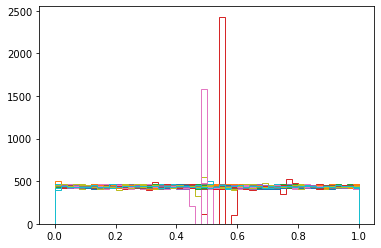

In [60]:
for i in range(100):
  plt.hist( X_train[:,i], 50,histtype= 'step')

In [61]:
X_train.shape

(21948, 1655)

In [62]:
# Tiếp cận theo hướng recommend - cell -> chemical | cell/gene: user, chemial: item
n_components = 256

u_fts_num = X_train.shape[1]#num_fts
i_fts_num = num_labels

#User embedding
input_u = Input(shape = (u_fts_num,) , name ='input_u1' )
layer_u = WeightNormalization(Dense(n_components, activation = 'relu', kernel_initializer='he_normal', name ='layer_u1')) (input_u)
layer_u = BatchNormalization() (layer_u)

#Item embedding
  # Addition information for item_info
chemical_category = tf.transpose(
        tf.constant(
            [[1 if '_inhibitor' in i else 0 for i in cols_target],
               [1 if '_agonist' in i else 0 for i in cols_target],
               [1 if '_agent' in i else 0 for i in cols_target],
               [1 if '_antagonist' in i else 0 for i in cols_target],
               [1 if '_blocker' in i else 0 for i in cols_target],
               [1 if '_activator' in i else 0 for i in cols_target] 
             ]))

  # Full item fts: addition + onehot
item_ft = tf.concat(
    [chemical_category ,
     tf.eye(i_fts_num, dtype = tf.int32) # Create tensor 0-1 coresponse with chemical labels
    ], axis = 1
)
layer_i = Dense(n_components, activation = 'relu', kernel_initializer='he_normal', name ='layer_u1') (item_ft)

# Dot product user - item
def dot_2layer(x):
    return K.dot( x[0], K.transpose(x[1]))
dot_ui = Lambda( dot_2layer, name = 'lambda_dot' ) ([layer_u,layer_i])
# dot_ui= BatchNormalization() (dot_ui)
dot_ui= WeightNormalization(Dense(512, activation="relu", kernel_initializer='he_normal')) (dot_ui)
# dot_ui= BatchNormalization() (dot_ui)
dot_ui= WeightNormalization(Dense(256, activation="relu", kernel_initializer='he_normal')) (dot_ui)
# dot_ui= BatchNormalization() (dot_ui)
dot_ui = Dense(i_fts_num, activation = 'sigmoid', kernel_initializer='he_normal', name = 'labels')(dot_ui)

# Compile model
model = Model(inputs=[input_u, ], outputs= [dot_ui])
opt = Adam(lr=0.0005)
model.compile(loss= BinaryCrossentropy(label_smoothing=0.0005), optimizer=opt)
print( model.summary() )

# tf.keras.utils.plot_model(model,show_shapes=True)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_u1 (InputLayer)        [(None, 1655)]            0         
_________________________________________________________________
weight_normalization_2 (Weig (None, 256)               848129    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
tf_op_layer_MatMul_1 (Tensor [(None, 206)]             0         
_________________________________________________________________
weight_normalization_3 (Weig (None, 512)               212481    
_________________________________________________________________
weight_normalization_4 (Weig (None, 256)               262913    
_________________________________________________________________
labels (Dense)               (None, 206)              

In [65]:
X_train.shape

(21948, 1655)

In [66]:
to_train_targets[cols_target].shape

(21948, 206)

In [64]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, mode='min', min_lr=1E-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=15, mode='min',restore_best_weights=True, verbose=1)

model.fit(X_train, to_train_targets[cols_target], batch_size=64, epochs=150,validation_split = 0.3
         ,callbacks=[reduce_lr, early_stopping])

Epoch 1/150


ValueError: ignored

In [ ]:
'''
Dùng batch 64 -> dùng tiếp 128 thì thấy loss giảm
Tăng batch_size lên 256 thì thấy val_loss tăng
Training không với batch 128 thì thấy loss vẫn cao
'''